# Number Sequence 
Consider that we observed the following sequence of integer numbers 18, 22, 45, 49, 86. What is the next number? 

# Initialization

In [18]:
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
spark = SparkSession \
    .builder \
    .appName("Python Spark Data Partitioning Example") \
    .getOrCreate()
sc = spark.sparkContext

# Generate data

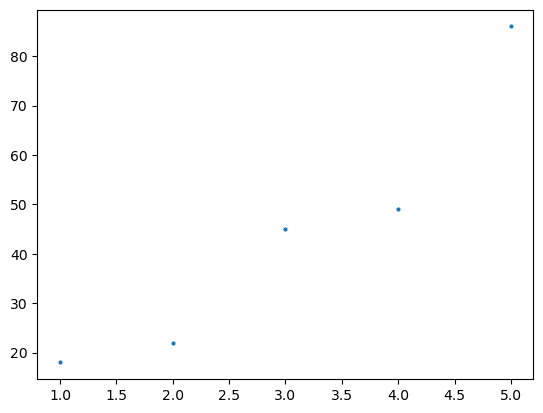

In [19]:
# Create number array
num_arr = np.array([18, 22, 45, 49, 86])

f = num_arr.copy()
t = np.arange(1, num_arr.size + 1)
plt.plot(t, f, 'o', markersize=2)
plt.show()

## Calculating the parameter m using sklearn. 
The fit() method returns an instance of the LinearRegression class, which contains the slope of the line in its coef_ attribute.

In [20]:
from sklearn.linear_model import LinearRegression

X = np.stack([t], axis=1)
reg = LinearRegression(fit_intercept=False).fit(X, f)
print(reg.coef_)

[14.96363636]


## Calculating the parameter using linear algebra
Calculate the coefficients of a linear regression model using the normal equation approach

$$
m = (X^T \cdot X)^{-1} \cdot X^T \cdot f
$$

Where:
- $m$ represents the estimated coefficients of the linear regression model.
- $X$ is the matrix of input variables.
- $X^T$ denotes the transpose of $X$.
- $f$ is the vector of dependent variable values.
- $(X^T \cdot X)^{-1}$ represents the inverse of the matrix product $X^T \cdot X$.

In [21]:
# Let use solve this also with the exact linear algebra solution. 
m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(f)

print(m)

[14.96363636]


# Caculating the parameter m using Gradient Descent
1. Calculate the prediction with current regression coefficients:
   - Prediction: $f_{\text{prediction}} = m_{\text{current}} \cdot t$

2. Compute the cost (for monitoring purposes):
   - Cost: $cost = \sum (f - f_{\text{prediction}})^2$

3. Calculation of the gradient:
   - Gradient: $m_{\text{gradient}} = \frac{-1}{n} \sum (t \cdot (f - f_{\text{prediction}}))$

4. Update of the regression coefficient:
   - Updated coefficient: $m_{\text{current}} = m_{\text{current}} - \text{learningRate} \cdot m_{\text{gradient}}$

Here, the variable $n$ represents the number of data points in the dataset, $y$ is the dependent variable, $x_1$ is the independent variable, $m_{\text{current}}$ is the current value of the coefficient, and $\text{learningRate}$ is the learning rate (step size) used in the gradient descent algorithm.

In [22]:
learningRate = 0.00001
numIteration = 30 
m_current = 0
n = float(f.size)

# Let's start with main iterative part of gradient descent algorithm 
for i in range(numIteration):
    # Calculate the prediction with current regression coefficients. 
    f_prediction = m_current * t 
    # Compute cost for monitoring 
    cost= sum (( f - f_prediction)**2)
    # Calculate gradients. 
    m_gradient = (-1.0/n) * sum (t * (f - f_prediction) )
    print(i,"m = ", m_current, " Cost = ", cost)
    # Update the weights - Regression Coefficients 
    m_current = m_current - learningRate * m_gradient 

0 m =  0  Cost =  12630
1 m =  0.0016460000000000003  Cost =  12627.29083301238
2 m =  0.0032918189400000008  Cost =  12624.582262008718
3 m =  0.004937456839916601  Cost =  12621.8742868579
4 m =  0.00658291371966421  Cost =  12619.166907428851
5 m =  0.008228189599155047  Cost =  12616.460123590516
6 m =  0.009873284498299141  Cost =  12613.753935211871
7 m =  0.011518198437004329  Cost =  12611.048342161928
8 m =  0.013162931435176259  Cost =  12608.343344309718
9 m =  0.01480748351271839  Cost =  12605.638941524305
10 m =  0.016451854689531992  Cost =  12602.935133674779
11 m =  0.018096044985516143  Cost =  12600.231920630267
12 m =  0.019740054420567737  Cost =  12597.529302259916
13 m =  0.021383883014581474  Cost =  12594.827278432902
14 m =  0.02302753078744987  Cost =  12592.125849018437
15 m =  0.02467099775906325  Cost =  12589.425013885757
16 m =  0.026314283949309753  Cost =  12586.724772904123
17 m =  0.02795738937807533  Cost =  12584.025125942833
18 m =  0.029600314065

## Calculating the parameter m using Gradient Descent in PySpark
- `num_rdd` contains tuples with the independent variable $x$ as the first element (`x[0]`) and the dependent variable $f$ as the second element (`x[1]`). 
- `size` represents the size of the RDD
- `learningRate` represents the learning rate (step size) used in the gradient descent algorithm.
- `m` represents the current value of the coefficient.
- `gradient` represents the gradient of the cost function.
- `cost` represents the value of the current cost function.

In [23]:
# Create number RDD as tuples of (1, 18),(2, 22),(3, 45),(4, 49),(5, 86) 
# that can be fitted on a line with the equation:
# f(t) = m × t 
num_rdd = sc.parallelize(zip(t,f))
num_rdd.take(5)

[(1, 18), (2, 22), (3, 45), (4, 49), (5, 86)]

In [24]:
# Now we do gradient Decent on our RDD data set. 
learningRate = 0.00001
numIteration = 30 
size = f.size
m = 0
num_rdd.cache()

# Gradient Descent algorithm 
for i in range(numIteration):
    gradientCost=num_rdd.map(lambda x: (x[0], (x[1] - x[0] * m))) \
                        .map(lambda x: (x[0] * x[1], x[1] ** 2)) \
                        .reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    cost= gradientCost[1]/(2*size)
    gradient=(-1.0/float(size))* gradientCost[0]
    print(i, "m = ", m, " Cost = ", cost)
    m = m - learningRate * gradient 

0 m =  0  Cost =  1263.0
1 m =  0.0016460000000000003  Cost =  1262.729083301238
2 m =  0.0032918189400000008  Cost =  1262.4582262008719
3 m =  0.004937456839916601  Cost =  1262.1874286857899
4 m =  0.00658291371966421  Cost =  1261.916690742885
5 m =  0.008228189599155047  Cost =  1261.6460123590516
6 m =  0.009873284498299141  Cost =  1261.375393521187
7 m =  0.011518198437004329  Cost =  1261.1048342161928
8 m =  0.013162931435176259  Cost =  1260.834334430972
9 m =  0.01480748351271839  Cost =  1260.5638941524305
10 m =  0.016451854689531992  Cost =  1260.2935133674778
11 m =  0.018096044985516143  Cost =  1260.0231920630267
12 m =  0.019740054420567737  Cost =  1259.7529302259916
13 m =  0.021383883014581474  Cost =  1259.4827278432901
14 m =  0.02302753078744987  Cost =  1259.2125849018437
15 m =  0.02467099775906325  Cost =  1258.9425013885757
16 m =  0.026314283949309753  Cost =  1258.6724772904122
17 m =  0.02795738937807533  Cost =  1258.4025125942833
18 m =  0.029600314065

# Close Spark Session

In [25]:
spark.stop()